# ContinuousDP: Stochastic Optimal Growth Model

In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using PyPlot
using Random

In [2]:
alpha = 0.4
beta = 0.96
mu = 0
sigma = 0.1;

In [3]:
f(s, x) = log(x)
g(s, x, e) = (s - x)^alpha * e;

In [4]:
shock_size = 250
shocks = exp.(mu .+ sigma * randn(shock_size))
weights = fill(1/shock_size, shock_size);

In [5]:
grid_max = 4.
n = 30
s_min, s_max = 1e-5, grid_max
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (1.0e-5,) × (4.0,).
Basis families are Cheb


In [6]:
x_lb(s) = s_min
x_ub(s) = s;

In [7]:
ab = alpha * beta
c1 = log(1 - ab) / (1 - beta)
c2 = (mu + alpha * log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

# True optimal policy
c_star(y) = (1 - alpha * beta) * y

# True value function
v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y);

In [8]:
cdp = ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis);

In [9]:
@code_warntype ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis)

Body::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}
│  60 1 ─ %1 = invoke ContinuousDPs.Interp(_9::Basis{1,Tuple{ChebParams{Float64}}})::ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},LinearAlgebra.LU{Float64,Array{Float64,2}}}
│╻╷ Type61 │   %2 = %new(ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}, f, g, discount, shocks, weights, x_lb, x_ub, %1)::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}
│  62 └──      return %2


## First test

In [10]:
C_star = cdp.interp.Phi \ v_star.(cdp.interp.S)
Tv = Array{Float64}(undef, cdp.interp.length)
C = copy(C_star)
bellman_operator!(cdp, C, Tv);

In [11]:
@code_warntype bellman_operator!(cdp, C, Tv)

Body::Array{Float64,1}
│╻ getproperty198 1 ─ %1 = (Base.getfield)(cdp, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:LinearAlgebra.Factorization where TM<:(AbstractArray{T,2} where T)
││    │   %2 = (Base.getfield)(%1, :S)::Array{Float64,1}
│     │   %3 = invoke ContinuousDPs.s_wise_max!(_2::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}, %2::Array{Float64,1}, _3::Array{Float64,1}, _4::Array{Float64,1})::Array{Float64,1}
│╻ getproperty199 │   %4 = (Base.getfield)(cdp, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:LinearAlgebra.Factorization where TM<:(AbstractArray{T,2} where T)
││    │   %5 = (Base.getfield)(%4, :Phi_lu)::LinearAlgebra.Factorization
│     │        (ContinuousDPs.ldiv!)(C, %5, %3)
│ 200 └──      return C


In [12]:
grid_size = 200
grid_y = collect(range(s_min, stop=s_max, length=grid_size))
V_approx = funeval(C, cdp.interp.basis, grid_y);

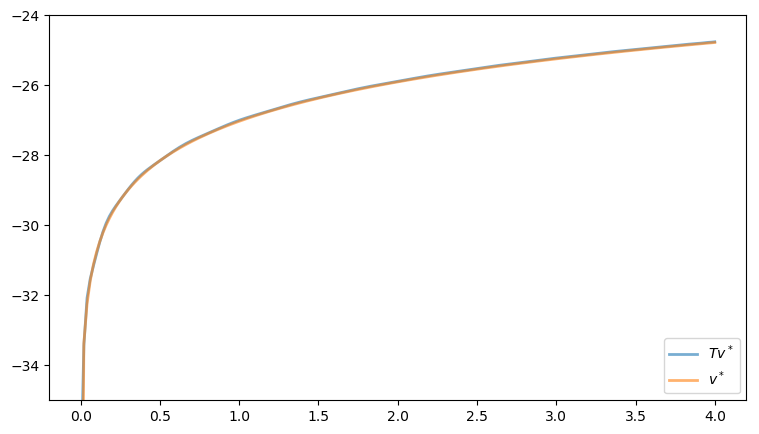

In [13]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, V_approx, lw=2, alpha=0.6, label=L"$Tv^*$")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label=L"$v^*$")
ax[:legend](loc="lower right")
show()

In [14]:
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv);

  0.106662 seconds (1.21 M allocations: 54.788 MiB, 19.19% gc time)
  0.083827 seconds (1.13 M allocations: 51.089 MiB, 11.62% gc time)
  0.091252 seconds (1.20 M allocations: 54.406 MiB, 13.58% gc time)


In [15]:
s = 2.
@code_warntype ContinuousDPs._s_wise_max(cdp, s, C)

Body::Tuple{Float64,Float64}
│╻       getproperty151 1 ── %1  = (Base.getfield)(cdp, :shocks)::Array{Float64,1}
│╻       size    │    %2  = (Base.arraysize)(%1, 1)::Int64
││╻       Type    │    %3  = $(Expr(:foreigncall, :(:jl_alloc_array_2d), Array{Float64,2}, svec(Any, Int64, Int64), :(:ccall), 3, Array{Float64,2}, :(%2), 1, 1, :(%2)))::Array{Float64,2}
│       152 │    %4  = %new(getfield(ContinuousDPs, Symbol("#objective#3")){ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)},Float64,Array{Float64,1},Array{Float64,2}}, cdp, s, C, %3)::getfield(ContinuousDPs, Symbol("#objective#3")){ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)},Float64,Array{Float64,1},Array{Float64,2}}
│       161 │    %5  = Optim.optimize::Core.Compiler.Const(Optim.optimize, false)
│╻       x_lb    │    %6  = Main.s_min::Any
│           │    %7  = (isa)(%6, Float64)::Bool
│           └───       goto #12 if not %7
│      

In [16]:
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C);

  0.002056 seconds (28.31 k allocations: 1.281 MiB)
  0.002404 seconds (28.29 k allocations: 1.278 MiB)
  0.002289 seconds (28.29 k allocations: 1.278 MiB)


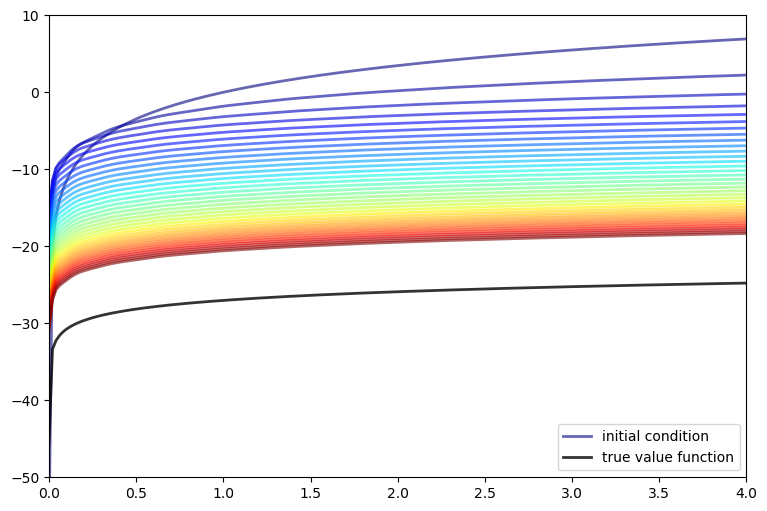

In [17]:
v_init_func(s) = 5 * log(s)
w = v_init_func.(grid_y)
n = 35

fig, ax = subplots(figsize=(9, 6))
ax[:set_ylim](-50, 10)
ax[:set_xlim](minimum(grid_y), maximum(grid_y))
lb = "initial condition"
jet = ColorMap("jet")
ax[:plot](grid_y, w, color=jet(0), lw=2, alpha=0.6, label=lb)

S = cdp.interp.S
V = v_init_func.(S)
for i in 1:n
    C = cdp.interp.Phi \ V
    bellman_operator!(cdp, C, V)
    w = funeval(C, cdp.interp.basis, grid_y)
    ax[:plot](grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

lb = "true value function"
ax[:plot](grid_y, v_star.(grid_y), "k-", lw=2, alpha=0.8, label=lb)
ax[:legend](loc="lower right")

show()

## Solve by policy iteration

In [18]:
res = solve(cdp);

Compute iterate 6 with error 1.0658141036401503e-13
Converged in 6 steps


In [19]:
@code_warntype solve(cdp)

Body::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
│ 296 1 ─ %1 = ContinuousDPs.PFI::Core.Compiler.Const(PFI, false)
│╻ solve    │   %2 = (Base.Math.sqrt_llvm)(2.220446049250313e-16)::Float64
││    │   %3 = invoke ContinuousDPs.:(#solve#7)(%2::Float64, 500::Int64, 2::Int64, 50::Int64, _1::Function, _2::ContinuousDP{1,Array{Float64,1},Array{Float64,1},typeof(f),typeof(g),typeof(x_lb),typeof(x_ub)}, %1::Type{PFI})::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
│     └──      return %3


In [20]:
@time res = solve(cdp)
@time res = solve(cdp)
@time res = solve(cdp);

Compute iterate 6 with error 1.0658141036401503e-13
Converged in 6 steps
  0.909546 seconds (11.46 M allocations: 571.261 MiB, 11.57% gc time)
Compute iterate 6 with error 1.0658141036401503e-13
Converged in 6 steps
  0.914953 seconds (11.46 M allocations: 571.270 MiB, 11.24% gc time)
Compute iterate 6 with error 1.0658141036401503e-13
Converged in 6 steps
  0.910241 seconds (11.46 M allocations: 571.270 MiB, 11.05% gc time)


In [21]:
set_eval_nodes!(res, grid_y);

In [22]:
@code_warntype set_eval_nodes!(res, grid_y)

Body::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
│╻╷ set_eval_nodes!137 1 ─ %1 = (Base.getfield)(s_nodes_coord, 1, true)::Array{Float64,1}
││╻  setproperty!    │        (Base.setfield!)(res, :eval_nodes, %1)
││╻  setproperty!    │        (Base.setfield!)(res, :eval_nodes_coord, s_nodes_coord)
│╻  set_eval_nodes!    │   %4 = invoke ContinuousDPs.evaluate!(_2::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}})::ContinuousDPs.CDPSolveResult{PFI,1,Array{Float64,1},Array{Float64,1}}
│      └──      return %4


In [23]:
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y);

  0.575157 seconds (7.74 M allocations: 349.491 MiB, 11.62% gc time)
  0.573510 seconds (7.74 M allocations: 349.491 MiB, 10.07% gc time)
  0.592195 seconds (7.74 M allocations: 349.491 MiB, 9.38% gc time)


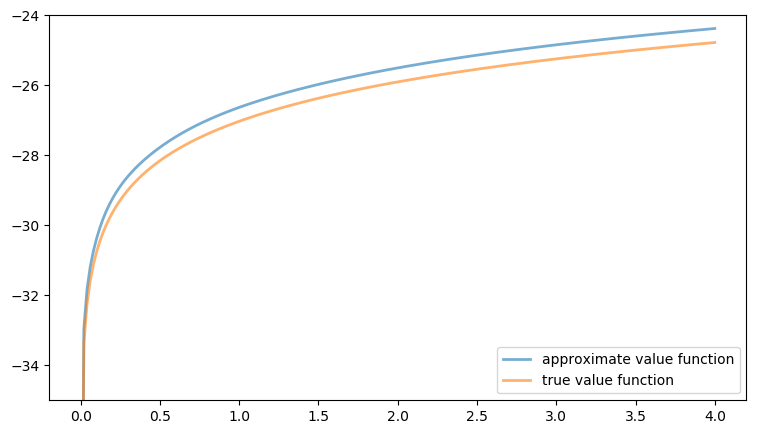

In [24]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, res.V, lw=2, alpha=0.6, label="approximate value function")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label="true value function")
ax[:legend](loc="lower right")
show()

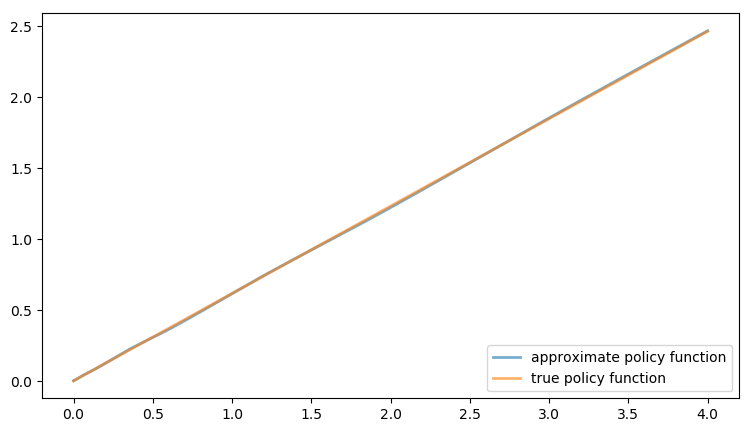

In [25]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.X, lw=2, alpha=0.6, label="approximate policy function")
ax[:plot](grid_y, c_star.(grid_y), lw=2, alpha=0.6, label="true policy function")
ax[:legend](loc="lower right")
show()

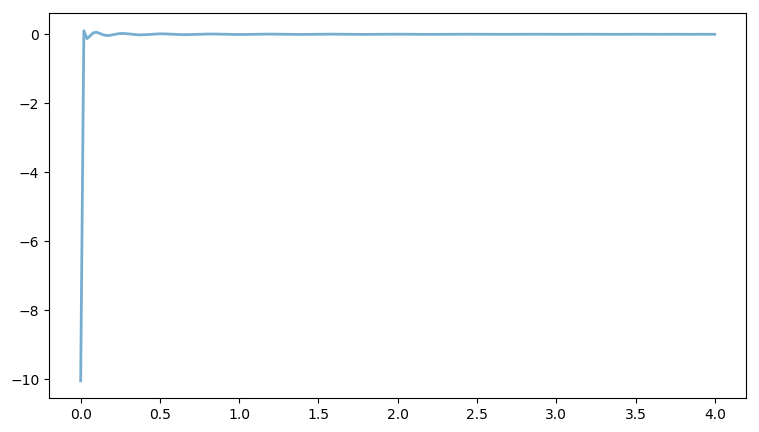

In [26]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.resid, lw=2, alpha=0.6, label="residual")
show()

## Simulate the controlled Markov process

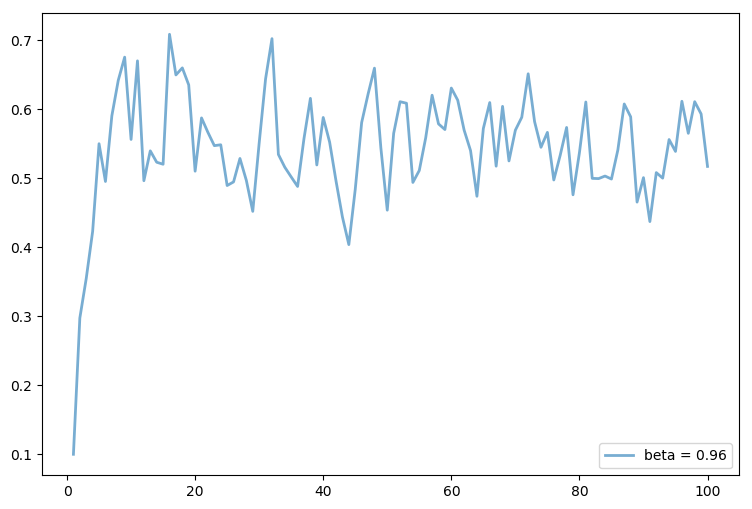

In [27]:
s_init = 0.1
ts_length = 100
y = simulate(res, s_init, ts_length)

fig, ax = subplots(figsize=(9, 6))
ax[:plot](1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
ax[:legend](loc="lower right")
show()

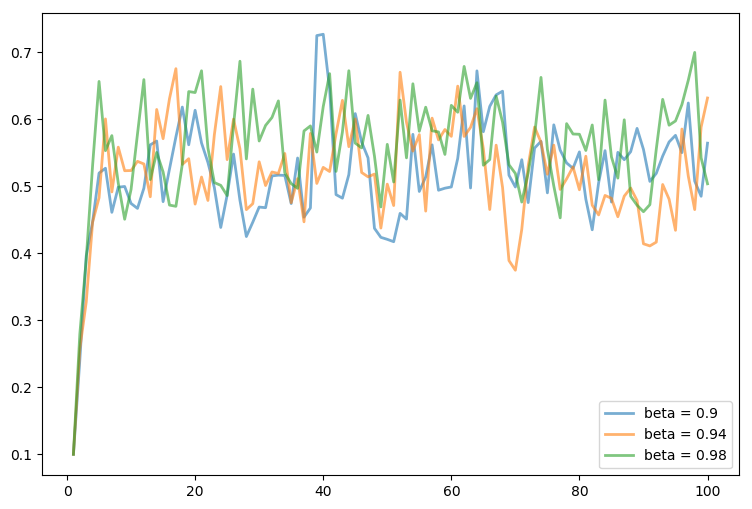

In [28]:
fig, ax = subplots(figsize=(9, 6))

for beta in (0.9, 0.94, 0.98)
    cdp.discount = beta
    res = solve(cdp, verbose=0)
    set_eval_nodes!(res, grid_y)
    y = simulate(res, s_init, ts_length)
    ax[:plot](1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
end

ax[:legend](loc="lower right")
show()

In [29]:
@code_warntype simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)

Body::Array{Float64,1}
│╻         size335 1 ── %1   = (Base.arraysize)(s_path, 1)::Int64
│╻         getproperty336 │    %2   = (Base.getfield)(res, :cdp)::ContinuousDP{1,Array{Float64,1},Array{Float64,1},Tf,Tg,Tlb,Tub} where Tub<:Function where Tlb<:Function where Tg<:Function where Tf<:Function
││            │    %3   = (Base.getfield)(%2, :weights)::Array{Float64,1}
│╻         cumsum    │           invoke Core.kwfunc(Base.cumsum::Any)
││            │    %5   = Base.cumsum::typeof(cumsum)
││╻╷╷╷╷     #cumsum    │    %6   = (Base.slt_int)(0, 1)::Bool
│││┃│││      isempty    └───        goto #3 if not %6
││││┃││       iterate    2 ──        goto #4
│││││┃│        iterate    3 ──        invoke Base.getindex(()::Tuple{}, 1::Int64)
││││││┃         iterate    └───        $(Expr(:unreachable))
││││││        4 ┄─        goto #5
││││╻         iterate    5 ──        goto #6
││││          6 ──        goto #7
│││           7 ── %14  = invoke Base.:(#cumsum#572)(1::Int64, %5::Function, %3::Array{F

│             42 ┄ %128 = φ (#41 => %124, #46 => %149)::Int64
│             │    %129 = φ (#41 => %125, #46 => %150)::Int64
│╻         getindex350 │    %130 = (Base.arrayref)(true, s_path, %128)::Float64
│╻╷╷╷╷╷╷   Interpoland351 │    %131 = $(Expr(:foreigncall, :(:jl_alloc_array_2d), Array{Float64,2}, svec(Any, Int64, Int64), :(:ccall), 3, Array{Float64,2}, 1, 1, 1, 1))::Array{Float64,2}
││┃│││      Interpoland    │    %132 = invoke Base.fill!(%131::Array{Float64,2}, %130::Float64)::Array{Float64,2}
│││┃         funeval    │    %133 = invoke BasisMatrices.funeval(%105::Array{Float64,1}, %102::Basis{1,Tuple{LinParams{Array{Float64,1}}}}, %132::Array{Float64,2}, 0::Int64)::Array{Float64,2}
││││╻         getindex    │    %134 = (Base.arrayref)(true, %133, 1)::Float64
│╻         getindex352 │    %135 = (Base.arrayref)(true, %43, %128)::Int64
│╻         getproperty    │    %136 = (Base.getfield)(res, :cdp)::ContinuousDP{1,Array{Float64,1},Array{Float64,1},Tf,Tg,Tlb,Tub} where Tub<:Function

In [30]:
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(undef, ts_length), res, s_init);

  0.000365 seconds (3.56 k allocations: 291.109 KiB)
  0.000315 seconds (3.55 k allocations: 289.953 KiB)
  0.000329 seconds (3.55 k allocations: 289.953 KiB)
